In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
pip install --upgrade tensorflow==2.13.0

In [ ]:
import tensorflow as tf
tf_version = tf.__version__

print("TensorFlow version:", tf_version)

**DATASET**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import metrics, Model, layers
from tensorflow.keras import layers, models, optimizers
from pathlib import Path
from PIL import Image

2024-04-11 10:00:19.530065: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-11 10:00:19.530178: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-11 10:00:19.642672: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from pathlib import Path
import os
import cv2

# Set the data directory path
data_dir = '/kaggle/input/cellimagesfordetectingmalaria/cell_images'

# Create the paths for parasitized and uninfected images
parasitized_data = list(Path(os.path.join(data_dir, 'Parasitized')).rglob('*.png'))
uninfected_data = list(Path(os.path.join(data_dir, 'Uninfected')).rglob('*.png'))

data = []
labels = []
IMG_SIZE = 130

In [3]:
for img_path in parasitized_data:
    try:
        img = cv2.imread(str(img_path))
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img_array = np.array(img)
        data.append(img_array)
        labels.append(1)
    except Exception as e:
        print(f"Error loading parasitized image {img_path}: {e}")

# Load uninfected images
for img_path in uninfected_data:
    try:
        img = cv2.imread(str(img_path))
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img_array = np.array(img)
        data.append(img_array)
        labels.append(0)
    except Exception as e:
        print(f"Error loading uninfected image {img_path}: {e}")

image_data = np.array(data)
labels = np.array(labels)

print("image_data shape:", image_data.shape)
print("labels shape:", labels.shape)

image_data shape: (27558, 130, 130, 3)
labels shape: (27558,)


**VISUALIZATION**

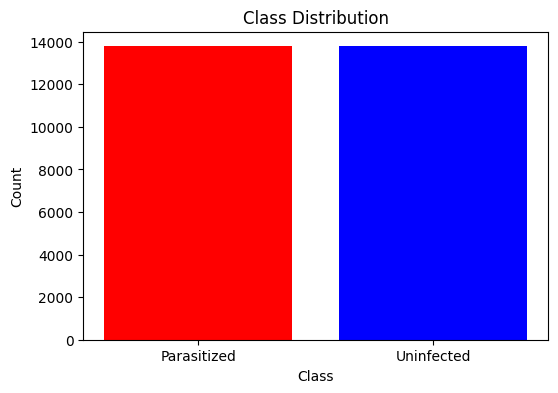

In [6]:
import matplotlib.pyplot as plt

# Class Distribution Bar Plot
plt.figure(figsize=(6, 4))
plt.bar(['Parasitized', 'Uninfected'], [np.sum(labels==1), np.sum(labels==0)], color=['red', 'blue'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()



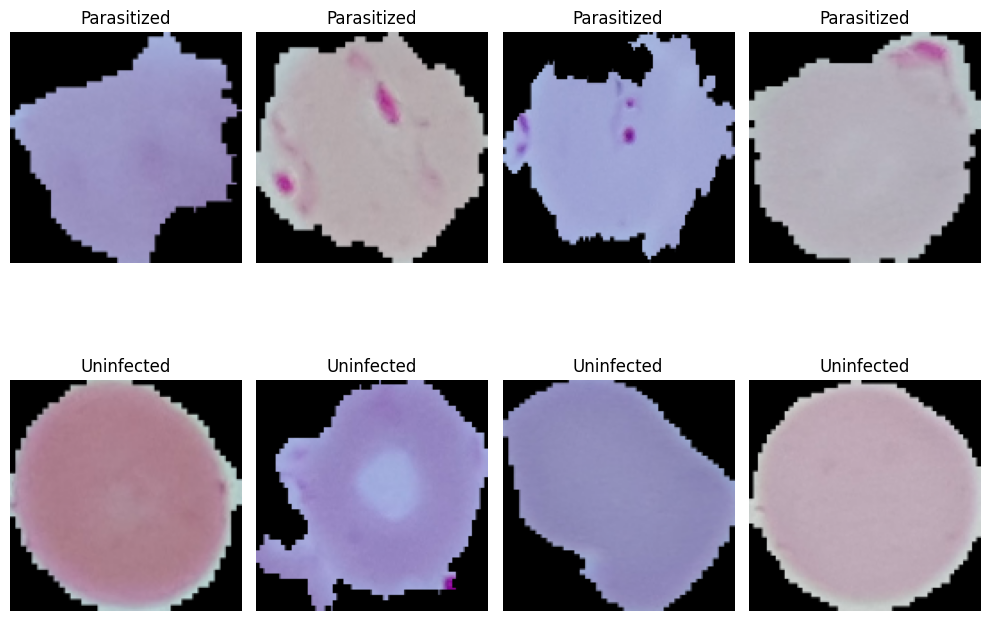

In [9]:
import matplotlib.pyplot as plt
import random
num_images = 8
num_rows = 2
num_cols = 4
# Get random indices for each class
parasitized_indices = np.where(labels == 1)[0]
uninfected_indices = np.where(labels == 0)[0]
# Choose random indices from each class
random_parasitized_indices = random.sample(list(parasitized_indices), num_images // 2)
random_uninfected_indices = random.sample(list(uninfected_indices), num_images // 2)
# Plot random images
plt.figure(figsize=(10, 8))
# Plot parasitized images
for i, idx in enumerate(random_parasitized_indices):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(image_data[idx])
    plt.title('Parasitized')
    plt.axis('off')
# Plot uninfected images
for i, idx in enumerate(random_uninfected_indices):
    plt.subplot(num_rows, num_cols, i + num_images // 2 + 1)
    plt.imshow(image_data[idx])
    plt.title('Uninfected')
    plt.axis('off')
plt.tight_layout()
plt.show()

**TEST - TRAIN SPLIT**

In [4]:
from sklearn.model_selection import train_test_split

# Shuffle the indices of the dataset
#indices = np.arange(len(image_data))
#np.random.shuffle(indices)

# Use the shuffled indices to shuffle the dataset
#shuffled_image_data = image_data[indices]
#shuffled_labels = labels[indices]

# Split the shuffled dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2, random_state=0)

# Normalize the pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0

# Convert labels to one-hot encoding
y_train = keras.utils.to_categorical(y_train, num_classes=2)
y_test = keras.utils.to_categorical(y_test, num_classes=2)

**DATA AUGMENTATION**

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
    

In [6]:
datagen.fit(X_train)
train_generator = datagen.flow(X_train, y_train, batch_size=32)

**TEST GTRAIN SPLIT VISUALIZATION**

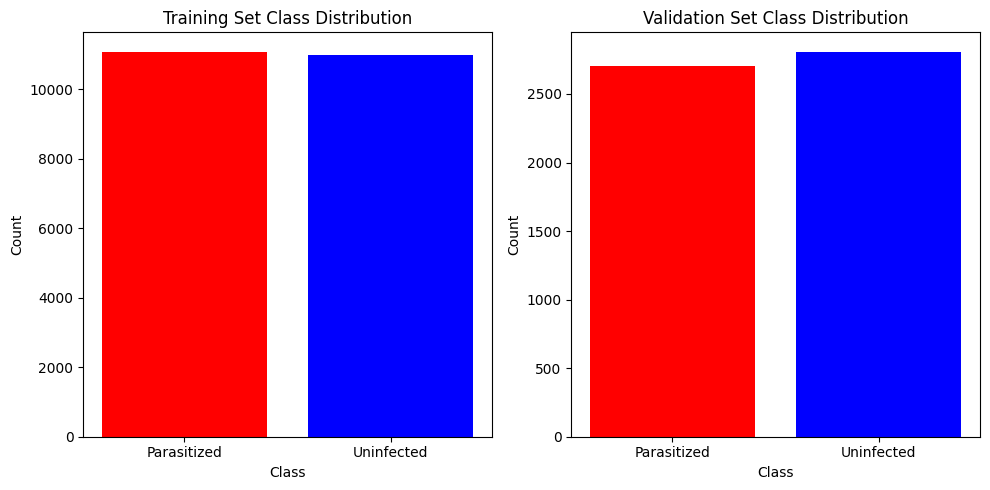

In [12]:
import matplotlib.pyplot as plt

# Calculate the number of parasitized and uninfected samples in training and testing sets
train_parasitized_count = np.sum(y_train[:, 1])
train_uninfected_count = np.sum(y_train[:, 0])
test_parasitized_count = np.sum(y_test[:, 1])
test_uninfected_count = np.sum(y_test[:, 0])

# Plot the counts in two different graphs
plt.figure(figsize=(10, 5))

# Plot training set counts
plt.subplot(1, 2, 1)
plt.bar(['Parasitized', 'Uninfected'], [train_parasitized_count, train_uninfected_count], color=['red', 'blue'])
plt.title('Training Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

# Plot testing set counts
plt.subplot(1, 2, 2)
plt.bar(['Parasitized', 'Uninfected'], [test_parasitized_count, test_uninfected_count], color=['red', 'blue'])
plt.title('Validation Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


**VGG16**

In [43]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import matplotlib.pyplot as plt
import numpy as np
from glob import glob


from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense

# Instantiating the VGG16 model
vgg16 = VGG16(
    input_shape=[IMG_SIZE, IMG_SIZE] + [3],
    weights='imagenet',  # Include the pre-trained weights on ImageNet
    include_top=False
)

for layer in vgg16.layers:
    layer.trainable = False

# Defining input and output to the model
x = Flatten()(vgg16.output)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.6)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.6)(x)
prediction = Dense(2, activation='softmax')(x)

# Creating a new model with our custom top layers
model_vgg16 = Model(inputs=vgg16.input, outputs=prediction)

# Print model summary
model_vgg16.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 130, 130, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 130, 130, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 130, 130, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 65, 65, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 65, 65, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 65, 65, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 4096)           │    33,558,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 2)              │         8,19

 Total params: 65,062,722 (248.19 MB)

 Trainable params: 50,348,034 (192.06 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [44]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.00001)
model_vgg16.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

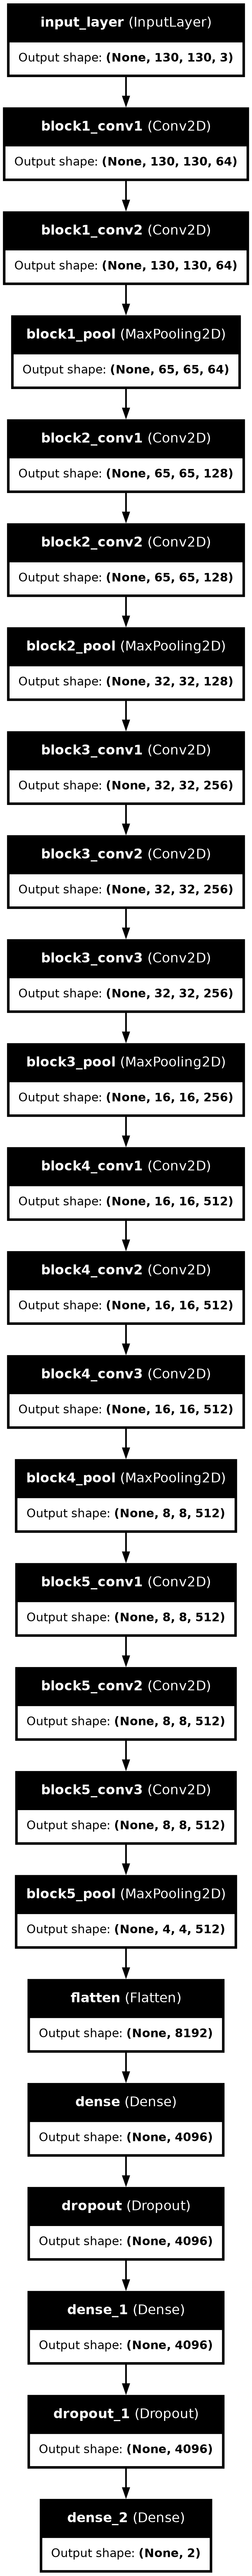

In [14]:
from tensorflow.keras.utils import plot_model

plot_model(model_vgg16, to_file='model_summary.png', show_shapes=True, show_layer_names=True)


In [45]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [17]:
history_vgg16_10 = model_vgg16.fit(train_generator, epochs=10, validation_data=(X_test, y_test),callbacks=[early_stopping])

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/689 ━━━━━━━━━━━━━━━━━━━━ 53s 77ms/step - accuracy: 0.3750 - loss: 0.9973   

I0000 00:00:1712738233.900569      90 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712738233.923763      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.6380 - loss: 0.6828

W0000 00:00:1712738353.478040      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


689/689 ━━━━━━━━━━━━━━━━━━━━ 152s 193ms/step - accuracy: 0.6381 - loss: 0.6827 - val_accuracy: 0.8607 - val_loss: 0.3102
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 110s 158ms/step - accuracy: 0.8267 - loss: 0.3948 - val_accuracy: 0.9026 - val_loss: 0.2504
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 110s 158ms/step - accuracy: 0.8499 - loss: 0.3507 - val_accuracy: 0.9146 - val_loss: 0.2258
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 109s 157ms/step - accuracy: 0.8634 - loss: 0.3243 - val_accuracy: 0.9211 - val_loss: 0.2171
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 109s 157ms/step - accuracy: 0.8779 - loss: 0.3025 - val_accuracy: 0.9120 - val_loss: 0.2182
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 110s 158ms/step - accuracy: 0.8822 - loss: 0.2935 - val_accuracy: 0.9251 - val_loss: 0.2003
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 109s 157ms/step - accuracy: 0.8861 - loss: 0.2840 - val_accuracy: 0.9202 - val_loss: 0.2073
Epoch 8/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 109s 157ms/step - accuracy: 0.8866 - loss: 0.28

In [40]:
history_vgg16_25 = model_vgg16.fit(train_generator, epochs=25, validation_data=(X_test, y_test),callbacks=[early_stopping])

Epoch 1/25
  2/689 ━━━━━━━━━━━━━━━━━━━━ 48s 71ms/step - accuracy: 0.2891 - loss: 1.1783  

W0000 00:00:1712745489.604016      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.6436 - loss: 0.6771

W0000 00:00:1712745594.518760      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


689/689 ━━━━━━━━━━━━━━━━━━━━ 119s 165ms/step - accuracy: 0.6437 - loss: 0.6769 - val_accuracy: 0.8765 - val_loss: 0.2932
Epoch 2/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 107s 155ms/step - accuracy: 0.8245 - loss: 0.3963 - val_accuracy: 0.9046 - val_loss: 0.2447
Epoch 3/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 108s 156ms/step - accuracy: 0.8541 - loss: 0.3401 - val_accuracy: 0.8870 - val_loss: 0.2617
Epoch 4/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 107s 154ms/step - accuracy: 0.8595 - loss: 0.3366 - val_accuracy: 0.9171 - val_loss: 0.2150
Epoch 5/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 107s 155ms/step - accuracy: 0.8760 - loss: 0.3069 - val_accuracy: 0.9084 - val_loss: 0.2264
Epoch 6/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 108s 155ms/step - accuracy: 0.8804 - loss: 0.2955 - val_accuracy: 0.9282 - val_loss: 0.1984
Epoch 7/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 107s 154ms/step - accuracy: 0.8873 - loss: 0.2809 - val_accuracy: 0.9240 - val_loss: 0.2029
Epoch 8/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 108s 155ms/step - accuracy: 0.8841 - loss: 0.28

In [46]:
history_vgg16_50 = model_vgg16.fit(train_generator, epochs=50, validation_data=(X_test, y_test),callbacks=[early_stopping])

Epoch 1/50
  2/689 ━━━━━━━━━━━━━━━━━━━━ 51s 74ms/step - accuracy: 0.4219 - loss: 1.1159  

W0000 00:00:1712748305.116287      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.6437 - loss: 0.6837

W0000 00:00:1712748409.985377      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


689/689 ━━━━━━━━━━━━━━━━━━━━ 119s 165ms/step - accuracy: 0.6438 - loss: 0.6835 - val_accuracy: 0.8815 - val_loss: 0.2920
Epoch 2/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 107s 154ms/step - accuracy: 0.8214 - loss: 0.3950 - val_accuracy: 0.9004 - val_loss: 0.2536
Epoch 3/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 108s 155ms/step - accuracy: 0.8556 - loss: 0.3435 - val_accuracy: 0.9017 - val_loss: 0.2452
Epoch 4/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 107s 154ms/step - accuracy: 0.8614 - loss: 0.3300 - val_accuracy: 0.9207 - val_loss: 0.2144
Epoch 5/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 107s 154ms/step - accuracy: 0.8761 - loss: 0.3095 - val_accuracy: 0.9274 - val_loss: 0.2047
Epoch 6/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 108s 155ms/step - accuracy: 0.8800 - loss: 0.2976 - val_accuracy: 0.9234 - val_loss: 0.2043
Epoch 7/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 107s 154ms/step - accuracy: 0.8776 - loss: 0.2970 - val_accuracy: 0.9069 - val_loss: 0.2263
Epoch 8/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 110s 158ms/step - accuracy: 0.8870 - loss: 0.28

In [ ]:
history_vgg16_75 = model_vgg16.fit(train_generator, epochs=75, validation_data=(X_test, y_test),callbacks=[early_stopping])

In [ ]:
history_vgg16_100 = model_vgg16.fit(train_generator, epochs=100, validation_data=(X_test, y_test),callbacks=[early_stopping])

In [34]:
VGG16_10_train_loss = history_vgg16_10.history['loss']
VGG16_10_val_loss = history_vgg16_10.history['val_loss']
VGG16_10_train_acc = history_vgg16_10.history['accuracy']
VGG16_10_val_acc = history_vgg16_10.history['val_accuracy']
print(VGG16_10_train_loss)
print(VGG16_10_val_loss)
print(VGG16_10_train_acc)
print(VGG16_10_val_acc)

[0.5590247511863708, 0.3831395208835602, 0.344210147857666, 0.31978297233581543, 0.2968178689479828, 0.2926594913005829, 0.28771674633026123, 0.2804209887981415, 0.2741430997848511, 0.2779374122619629]
[0.3101825416088104, 0.2504107654094696, 0.22579850256443024, 0.21711069345474243, 0.21815770864486694, 0.20030705630779266, 0.20727267861366272, 0.19057317078113556, 0.19072851538658142, 0.18816816806793213]
[0.7198131084442139, 0.8329855799674988, 0.8526716828346252, 0.8671414256095886, 0.8799782395362854, 0.8802957534790039, 0.8846502900123596, 0.888823390007019, 0.8910006284713745, 0.8883697986602783]
[0.8606676459312439, 0.902576208114624, 0.9145500659942627, 0.9210813045501709, 0.912010133266449, 0.9250725507736206, 0.9201741814613342, 0.9341436624526978, 0.9348693490028381, 0.9359579086303711]


In [42]:
VGG16_25_train_loss = history_vgg16_25.history['loss']
VGG16_25_val_loss = history_vgg16_25.history['val_loss']
VGG16_25_train_acc = history_vgg16_25.history['accuracy']
VGG16_25_val_acc = history_vgg16_25.history['val_accuracy']
print(VGG16_25_train_loss)
print(VGG16_25_val_loss)
print(VGG16_25_train_acc)
print(VGG16_25_val_acc)

[0.5525930523872375, 0.3791007399559021, 0.34094518423080444, 0.32486456632614136, 0.3052830398082733, 0.293099045753479, 0.28521060943603516, 0.2841886878013611, 0.28140756487846375, 0.27633029222488403, 0.26462170481681824, 0.2692596912384033, 0.261636883020401, 0.26160576939582825, 0.26166778802871704, 0.25728967785835266, 0.2546086311340332, 0.25289398431777954, 0.2548463046550751, 0.25376638770103455, 0.25178152322769165, 0.2469741553068161, 0.2493681013584137, 0.25078877806663513, 0.24314165115356445]
[0.2932010889053345, 0.2446897029876709, 0.2616513967514038, 0.21504969894886017, 0.2264065444469452, 0.19836796820163727, 0.20287999510765076, 0.19392231106758118, 0.1902729719877243, 0.1915493607521057, 0.19677583873271942, 0.1964958757162094, 0.1784553974866867, 0.18495193123817444, 0.18589793145656586, 0.1927919089794159, 0.17458617687225342, 0.20349237322807312, 0.19036898016929626, 0.1726226955652237, 0.1786258965730667, 0.17234067618846893, 0.18654142320156097, 0.176794588565

In [47]:
VGG16_50_train_loss = history_vgg16_50.history['loss']
VGG16_50_val_loss = history_vgg16_50.history['val_loss']
VGG16_50_train_acc = history_vgg16_50.history['accuracy']
VGG16_50_val_acc = history_vgg16_50.history['val_accuracy']
print(VGG16_50_train_loss)
print(VGG16_50_val_loss)
print(VGG16_50_train_acc)
print(VGG16_50_val_acc)

[0.5585228204727173, 0.38166365027427673, 0.3417353332042694, 0.3239413797855377, 0.30455148220062256, 0.2923204004764557, 0.28959017992019653, 0.2794591188430786, 0.27715781331062317, 0.27249598503112793, 0.2708961069583893, 0.26955077052116394, 0.2643031179904938, 0.26339519023895264, 0.2539573907852173, 0.2576601207256317, 0.26147034764289856, 0.2515917420387268, 0.24845288693904877, 0.2500463128089905, 0.2500981390476227, 0.2514871656894684, 0.24856051802635193, 0.2492755949497223, 0.24741287529468536, 0.24741314351558685, 0.24813291430473328, 0.2490682452917099, 0.24300986528396606, 0.24111372232437134, 0.24406038224697113, 0.24169950187206268, 0.23874151706695557, 0.24167682230472565, 0.2358390837907791, 0.23919396102428436, 0.24052301049232483, 0.24035225808620453, 0.23789548873901367, 0.22944222390651703, 0.238666832447052, 0.23331131041049957, 0.23755721747875214, 0.23676185309886932, 0.23082877695560455, 0.23803387582302094, 0.23242515325546265, 0.23272983729839325, 0.2315582

In [ ]:
history_vgg16_10.history['accuracy'] = []
history_vgg16_10.history['val_accuracy'] = []
history_vgg16_10.history['loss'] = []
history_vgg16_10.history['val_loss'] = []

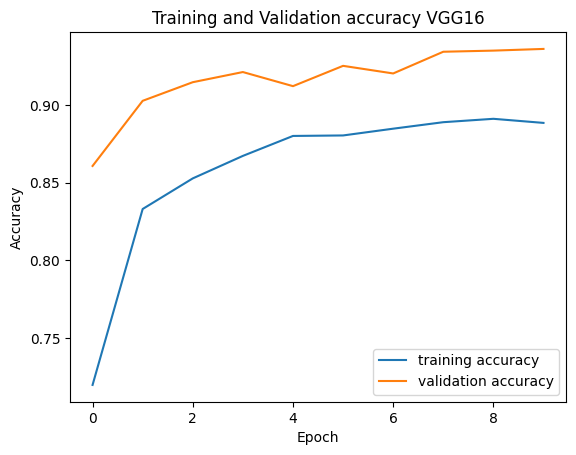

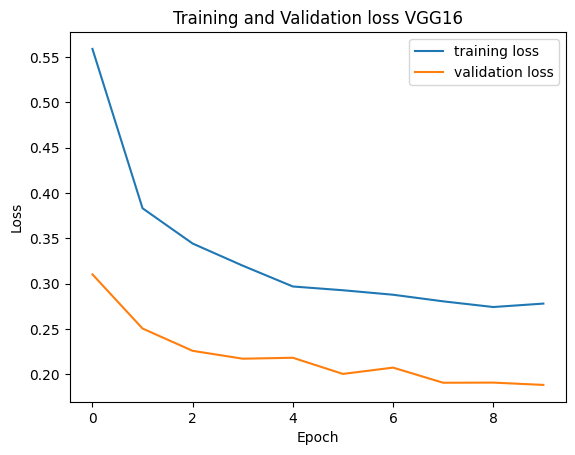

In [18]:
plt.plot(history_vgg16_10.history['accuracy'], label='training accuracy')
plt.plot(history_vgg16_10.history['val_accuracy'], label='validation accuracy')
plt.title('Training and Validation accuracy VGG16')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history_vgg16_10.history['loss'], label='training loss')
plt.plot(history_vgg16_10.history['val_loss'], label='validation loss')
plt.title('Training and Validation loss VGG16')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

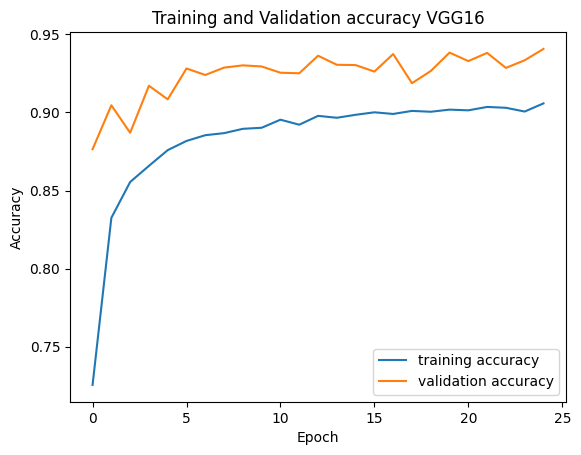

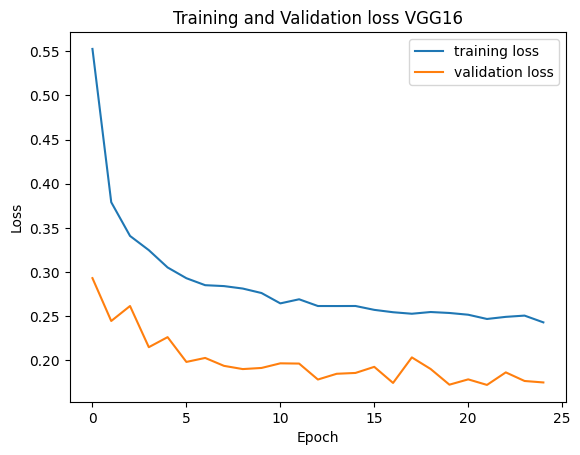

In [41]:
plt.plot(history_vgg16_25.history['accuracy'], label='training accuracy')
plt.plot(history_vgg16_25.history['val_accuracy'], label='validation accuracy')
plt.title('Training and Validation accuracy VGG16')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history_vgg16_25.history['loss'], label='training loss')
plt.plot(history_vgg16_25.history['val_loss'], label='validation loss')
plt.title('Training and Validation loss VGG16')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

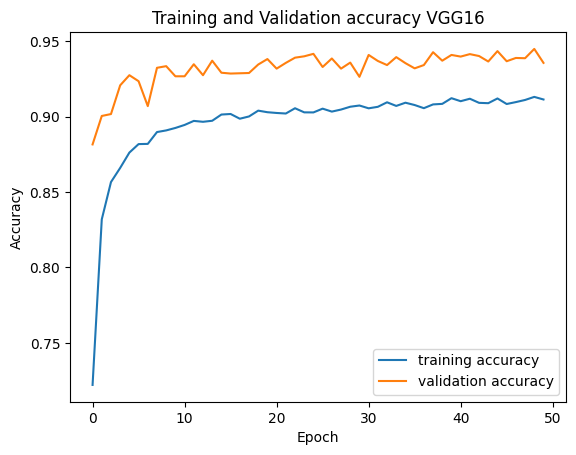

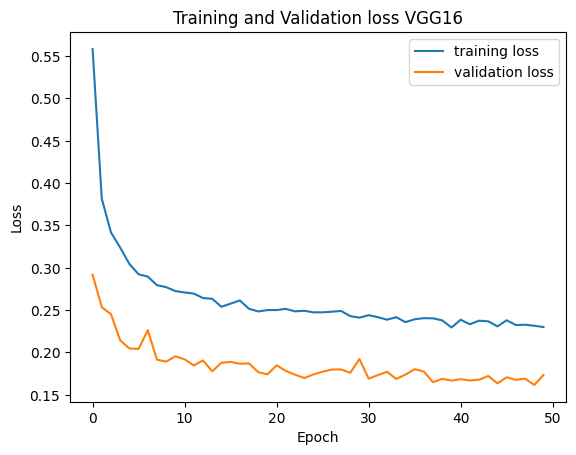

In [48]:
plt.plot(history_vgg16_50.history['accuracy'], label='training accuracy')
plt.plot(history_vgg16_50.history['val_accuracy'], label='validation accuracy')
plt.title('Training and Validation accuracy VGG16')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history_vgg16_50.history['loss'], label='training loss')
plt.plot(history_vgg16_50.history['val_loss'], label='validation loss')
plt.title('Training and Validation loss VGG16')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

# Predict labels for training data
train_predictions = model_vgg16.predict(X_train)
train_predictions_classes = np.argmax(train_predictions, axis=1)
y_train_classes = np.argmax(y_train, axis=1)

# Calculate training accuracy
train_accuracy = accuracy_score(y_train_classes, train_predictions_classes)

# Predict labels for testing data
test_predictions = model_vgg16.predict(X_test)
test_predictions_classes = np.argmax(test_predictions, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculate testing accuracy
test_accuracy = accuracy_score(y_test_classes, test_predictions_classes)

print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)


In [ ]:
from sklearn.metrics import classification_report

# Generate classification report for training data
train_classification_report = classification_report(y_train_classes, train_predictions_classes)

# Generate classification report for testing data
test_classification_report = classification_report(y_test_classes, test_predictions_classes)

print("Classification Report for Training Data:")
print(train_classification_report)

print("\nClassification Report for Testing Data:")
print(test_classification_report)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix

y_pred_proba = model_vgg16.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
cm = confusion_matrix(y_test[:, 1], y_pred)

fpr, tpr, thresholds = roc_curve(y_test[:, 1], y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(['uninfected', 'parasitized']))
plt.xticks(tick_marks, ['uninfected', 'parasitized'], rotation=45)
plt.yticks(tick_marks, ['uninfected', 'parasitized'])
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

**VGG19**

In [20]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import matplotlib.pyplot as plt
import numpy as np
from glob import glob

# To avoid warnings
import warnings
warnings.filterwarnings('ignore')

In [37]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Flatten, Dense

# Instantiating the VGG16 model
vgg19 = VGG19(
    input_shape=[IMG_SIZE, IMG_SIZE] + [3],
    weights='imagenet',  # Include the pre-trained weights on ImageNet
    include_top=False
)

for layer in vgg19.layers:
    layer.trainable = False

# Defining input and output to the model
x = Flatten()(vgg19.output)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.6)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.6)(x)
prediction = Dense(2, activation='softmax')(x)

# Creating a new model with our custom top layers
model_vgg19 = Model(inputs=vgg19.input, outputs=prediction)

# Print model summary
model_vgg19.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 130, 130, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 130, 130, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 130, 130, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 65, 65, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 65, 65, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 65, 65, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 4096)           │    33,558,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 4096)           │             

 Total params: 70,372,418 (268.45 MB)

 Trainable params: 50,348,034 (192.06 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [38]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.00001)
model_vgg19.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])



In [39]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [40]:
history_vgg19_10 = model_vgg19.fit(train_generator, epochs=10, validation_data=(X_test, y_test),callbacks=[early_stopping])

Epoch 1/10
  2/689 ━━━━━━━━━━━━━━━━━━━━ 1:00 87ms/step - accuracy: 0.5234 - loss: 1.0869 

W0000 00:00:1712842122.811925      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.6280 - loss: 0.7055

W0000 00:00:1712842227.118095      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


689/689 ━━━━━━━━━━━━━━━━━━━━ 120s 166ms/step - accuracy: 0.6281 - loss: 0.7053 - val_accuracy: 0.8605 - val_loss: 0.3349
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 108s 155ms/step - accuracy: 0.8042 - loss: 0.4204 - val_accuracy: 0.8694 - val_loss: 0.3053
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 108s 155ms/step - accuracy: 0.8379 - loss: 0.3736 - val_accuracy: 0.8875 - val_loss: 0.2839
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 108s 155ms/step - accuracy: 0.8523 - loss: 0.3459 - val_accuracy: 0.8832 - val_loss: 0.2751
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 108s 155ms/step - accuracy: 0.8663 - loss: 0.3230 - val_accuracy: 0.8989 - val_loss: 0.2598
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 108s 155ms/step - accuracy: 0.8663 - loss: 0.3230 - val_accuracy: 0.9033 - val_loss: 0.2513
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 109s 156ms/step - accuracy: 0.8686 - loss: 0.3152 - val_accuracy: 0.9031 - val_loss: 0.2511
Epoch 8/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 110s 158ms/step - accuracy: 0.8721 - loss: 0.30

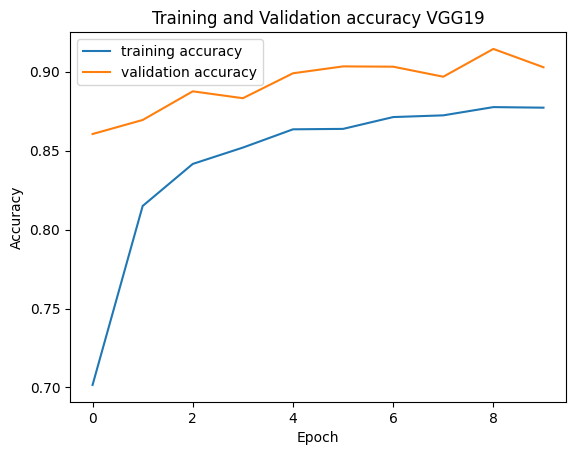

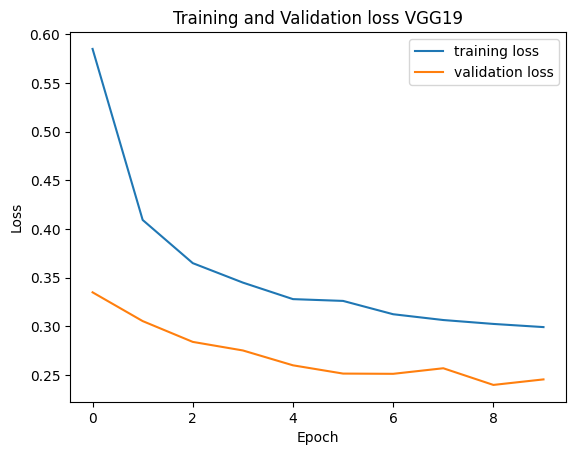

In [41]:
plt.plot(history_vgg19_10.history['accuracy'], label='training accuracy')
plt.plot(history_vgg19_10.history['val_accuracy'], label='validation accuracy')
plt.title('Training and Validation accuracy VGG19')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history_vgg19_10.history['loss'], label='training loss')
plt.plot(history_vgg19_10.history['val_loss'], label='validation loss')
plt.title('Training and Validation loss VGG19')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [42]:
VGG19_10_train_loss = history_vgg19_10.history['loss']
VGG19_10_val_loss = history_vgg19_10.history['val_loss']
VGG19_10_train_acc = history_vgg19_10.history['accuracy']
VGG19_10_val_acc = history_vgg19_10.history['val_accuracy']
print(VGG19_10_train_loss)
print(VGG19_10_val_loss)
print(VGG19_10_train_acc)
print(VGG19_10_val_acc)

[0.5851495265960693, 0.40928754210472107, 0.36488065123558044, 0.3448805809020996, 0.32788607478141785, 0.3260497748851776, 0.31234705448150635, 0.3063949644565582, 0.30238258838653564, 0.2991263270378113]
[0.3348727226257324, 0.3052980899810791, 0.2839132845401764, 0.275106817483902, 0.2598283290863037, 0.2513236999511719, 0.2510823905467987, 0.25681084394454956, 0.2396693378686905, 0.2453502118587494]
[0.7016238570213318, 0.8149324059486389, 0.841558575630188, 0.851900577545166, 0.863467276096344, 0.8637394309043884, 0.8712238073348999, 0.8723124265670776, 0.8775287866592407, 0.8771659135818481]
[0.8604862093925476, 0.8693758845329285, 0.8875181674957275, 0.8831639885902405, 0.8989477753639221, 0.9033018946647644, 0.9031204581260681, 0.8967706561088562, 0.9143686294555664, 0.9027576446533203]


In [24]:
history_vgg19_25 = model_vgg19.fit(train_generator, epochs=25, validation_data=(X_test, y_test),callbacks=[early_stopping])

Epoch 1/25
  2/689 ━━━━━━━━━━━━━━━━━━━━ 44s 65ms/step - accuracy: 0.5859 - loss: 0.7884   

W0000 00:00:1712835597.890665      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.6222 - loss: 0.7197

W0000 00:00:1712835713.142186      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


689/689 ━━━━━━━━━━━━━━━━━━━━ 148s 189ms/step - accuracy: 0.6223 - loss: 0.7196 - val_accuracy: 0.8545 - val_loss: 0.3411
Epoch 2/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 106s 153ms/step - accuracy: 0.8052 - loss: 0.4245 - val_accuracy: 0.8480 - val_loss: 0.3369
Epoch 3/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 105s 151ms/step - accuracy: 0.8347 - loss: 0.3721 - val_accuracy: 0.8790 - val_loss: 0.2878
Epoch 4/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 106s 152ms/step - accuracy: 0.8525 - loss: 0.3479 - val_accuracy: 0.8922 - val_loss: 0.2672
Epoch 5/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 105s 151ms/step - accuracy: 0.8595 - loss: 0.3283 - val_accuracy: 0.8935 - val_loss: 0.2637
Epoch 6/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 105s 151ms/step - accuracy: 0.8713 - loss: 0.3142 - val_accuracy: 0.8835 - val_loss: 0.2745
Epoch 7/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 105s 152ms/step - accuracy: 0.8699 - loss: 0.3167 - val_accuracy: 0.8989 - val_loss: 0.2493
Epoch 8/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 109s 156ms/step - accuracy: 0.8670 - loss: 0.32

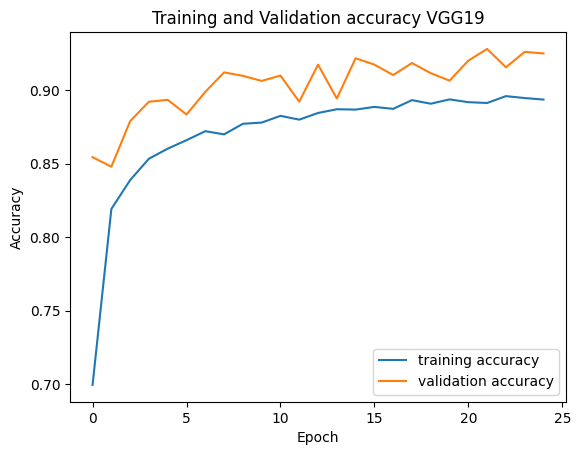

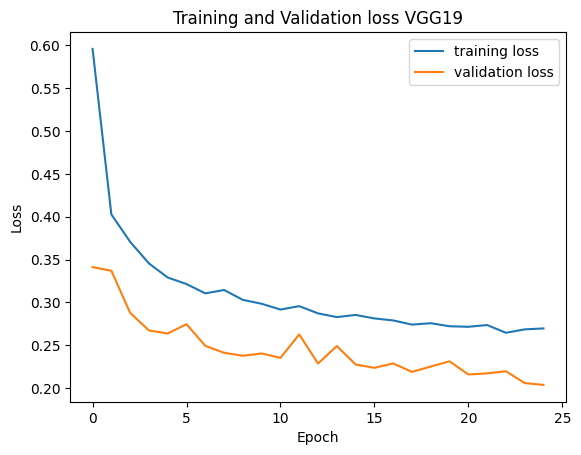

In [25]:
plt.plot(history_vgg19_25.history['accuracy'], label='training accuracy')
plt.plot(history_vgg19_25.history['val_accuracy'], label='validation accuracy')
plt.title('Training and Validation accuracy VGG19')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history_vgg19_25.history['loss'], label='training loss')
plt.plot(history_vgg19_25.history['val_loss'], label='validation loss')
plt.title('Training and Validation loss VGG19')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
VGG19_25_train_loss = history_vgg19_25.history['loss']
VGG19_25_val_loss = history_vgg19_25.history['val_loss']
VGG19_25_train_acc = history_vgg19_25.history['accuracy']
VGG19_25_val_acc = history_vgg19_25.history['val_accuracy']
print(VGG19_25_train_loss)
print(VGG19_25_val_loss)
print(VGG19_25_train_acc)
print(VGG19_25_val_acc)

[0.5958927869796753, 0.4026851952075958, 0.3707295358181, 0.34547072649002075, 0.3290138244628906, 0.3213949203491211, 0.3105091154575348, 0.31445783376693726, 0.30292201042175293, 0.29837357997894287, 0.2916436195373535, 0.2956109046936035, 0.2871497571468353, 0.2828248143196106, 0.2853497564792633, 0.28126081824302673, 0.2789202928543091, 0.2740631103515625, 0.27567043900489807, 0.272133469581604, 0.27149826288223267, 0.2735520899295807, 0.26450368762016296, 0.26848864555358887, 0.2695907950401306]
[0.341115802526474, 0.3369305729866028, 0.28779682517051697, 0.2672281563282013, 0.2637145221233368, 0.2745356261730194, 0.24925938248634338, 0.2411801517009735, 0.23767299950122833, 0.24035966396331787, 0.23521634936332703, 0.2625771760940552, 0.22857046127319336, 0.24902358651161194, 0.22754035890102386, 0.22359061241149902, 0.22872337698936462, 0.21884645521640778, 0.22511796653270721, 0.23118916153907776, 0.21582941710948944, 0.2171180099248886, 0.21959196031093597, 0.20579369366168976

In [53]:
history_vgg19_50 = model_vgg19.fit(train_generator, epochs=50, validation_data=(X_test, y_test),callbacks=[early_stopping])

Epoch 1/50
  2/689 ━━━━━━━━━━━━━━━━━━━━ 58s 86ms/step - accuracy: 0.5312 - loss: 0.8401  

W0000 00:00:1712753835.236749      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.6308 - loss: 0.7108

W0000 00:00:1712753939.601187      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


689/689 ━━━━━━━━━━━━━━━━━━━━ 121s 167ms/step - accuracy: 0.6309 - loss: 0.7106 - val_accuracy: 0.8433 - val_loss: 0.3467
Epoch 2/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 107s 153ms/step - accuracy: 0.8085 - loss: 0.4175 - val_accuracy: 0.8373 - val_loss: 0.3586
Epoch 3/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 108s 156ms/step - accuracy: 0.8328 - loss: 0.3783 - val_accuracy: 0.8846 - val_loss: 0.2803
Epoch 4/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 109s 156ms/step - accuracy: 0.8533 - loss: 0.3478 - val_accuracy: 0.8921 - val_loss: 0.2690
Epoch 5/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 108s 156ms/step - accuracy: 0.8580 - loss: 0.3319 - val_accuracy: 0.9028 - val_loss: 0.2574
Epoch 6/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 108s 156ms/step - accuracy: 0.8637 - loss: 0.3234 - val_accuracy: 0.8999 - val_loss: 0.2512
Epoch 7/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 108s 155ms/step - accuracy: 0.8667 - loss: 0.3244 - val_accuracy: 0.8942 - val_loss: 0.2579
Epoch 8/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 108s 155ms/step - accuracy: 0.8759 - loss: 0.30

In [ ]:
history_vgg19_75 = model_vgg19.fit(train_generator, epochs=75, validation_data=(X_test, y_test),callbacks=[early_stopping])

In [ ]:
history_vgg19_100 = model_vgg19.fit(train_generator, epochs=100, validation_data=(X_test, y_test),callbacks=[early_stopping])

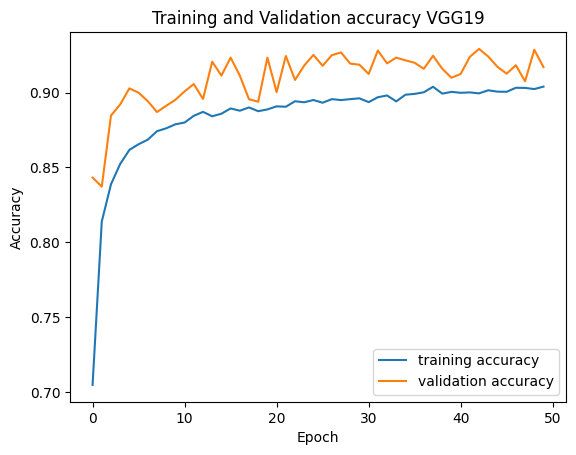

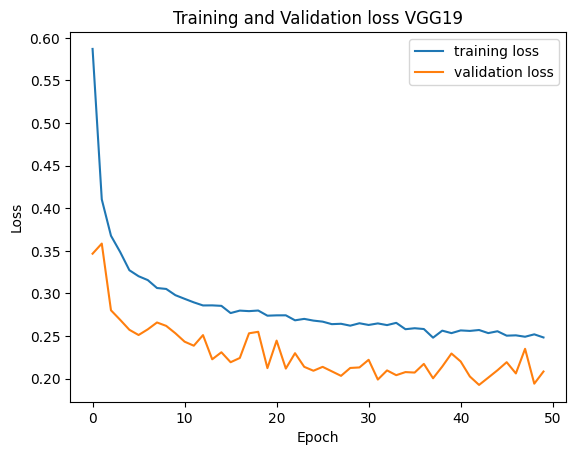

In [54]:
plt.plot(history_vgg19_50.history['accuracy'], label='training accuracy')
plt.plot(history_vgg19_50.history['val_accuracy'], label='validation accuracy')
plt.title('Training and Validation accuracy VGG19')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history_vgg19_50.history['loss'], label='training loss')
plt.plot(history_vgg19_50.history['val_loss'], label='validation loss')
plt.title('Training and Validation loss VGG19')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [55]:
VGG19_50_train_loss = history_vgg19_50.history['loss']
VGG19_50_val_loss = history_vgg19_50.history['val_loss']
VGG19_50_train_acc = history_vgg19_50.history['accuracy']
VGG19_50_val_acc = history_vgg19_50.history['val_accuracy']
print(VGG19_50_train_loss)
print(VGG19_50_val_loss)
print(VGG19_50_train_acc)
print(VGG19_50_val_acc)

[0.5870481133460999, 0.41044893860816956, 0.36775892972946167, 0.34863990545272827, 0.3272837996482849, 0.3202478885650635, 0.3157021701335907, 0.3064088225364685, 0.3053168058395386, 0.2979993224143982, 0.2937343716621399, 0.28957241773605347, 0.28594717383384705, 0.286031037569046, 0.2854704260826111, 0.2770022451877594, 0.27989035844802856, 0.27926871180534363, 0.27998217940330505, 0.27392280101776123, 0.27431535720825195, 0.27435651421546936, 0.2684934735298157, 0.27017393708229065, 0.2681577801704407, 0.26694005727767944, 0.2639922499656677, 0.2644307017326355, 0.2622043192386627, 0.26503339409828186, 0.2630465626716614, 0.2648542523384094, 0.2628733813762665, 0.2655191719532013, 0.25805237889289856, 0.25919875502586365, 0.2582702934741974, 0.24812281131744385, 0.2563600242137909, 0.2534574568271637, 0.25663676857948303, 0.2560445964336395, 0.25711581110954285, 0.25348323583602905, 0.25565576553344727, 0.2504710555076599, 0.2508598566055298, 0.24921059608459473, 0.2520298957824707

**RESNET18**

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

In [43]:
# Basic Block for ResNet
def basic_block(input_tensor, filters, stride=1):
    x = Conv2D(filters, (3, 3), strides=stride, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    shortcut = input_tensor
    if stride != 1 or input_tensor.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same')(input_tensor)
        shortcut = BatchNormalization()(shortcut)

    x = Activation('relu')(x + shortcut)
    return x

In [44]:
def ResNet18(input_shape=(130, 130, 3), num_classes=2):
    input_tensor = Input(shape=input_shape)

    x = Conv2D(64, (7, 7), strides=2, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Stack of Basic Blocks
    x = basic_block(x, filters=64, stride=1)
    x = basic_block(x, filters=64, stride=1)

    x = basic_block(x, filters=128, stride=2)
    x = basic_block(x, filters=128, stride=1)

    x = basic_block(x, filters=256, stride=2)
    x = basic_block(x, filters=256, stride=1)

    x = basic_block(x, filters=512, stride=2)
    x = basic_block(x, filters=512, stride=1)

    # Global Average Pooling
    x = AveragePooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    prediction = Dense(num_classes, activation='softmax')(x)
    model_resnet18 = Model(inputs=input_tensor, outputs=prediction, name='resnet18')
    return model_resnet18

# Creating an instance of ResNet-18
model_resnet18 = ResNet18()

# Printing the model summary
model_resnet18.summary()

Model: "resnet18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 130, 130,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 65, 65,    │      9,472 │ input_layer_6[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 65, 65,    │        256 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_34       │ (None, 65, 65,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 33, 33,    │          0 │ activation_34[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 33, 33,    │     36,928 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        256 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_35       │ (None, 33, 33,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 33, 33,    │     36,928 │ activation_35[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        256 │ conv2d_42[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 33, 33,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_36       │ (None, 33, 33,    │          0 │ add_16[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 33, 33,    │     36,928 │ activation_36[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        256 │ conv2d_43[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_37       │ (None, 33, 33,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 33, 33,    │     36,928 │ activation_37[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        256 │ conv2d_44[0][0] 

 Total params: 19,591,810 (74.74 MB)

 Trainable params: 19,582,210 (74.70 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [45]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.00001)
model_resnet18.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])



In [46]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [ ]:
history_resnet18_10 = model_resnet18.fit(train_generator, epochs=10, validation_data=(X_test, y_test),callbacks=[early_stopping])

In [ ]:
history_resnet18_25 = model_resnet18.fit(train_generator, epochs=25, validation_data=(X_test, y_test),callbacks=[early_stopping])

Epoch 1/25
  2/689 ━━━━━━━━━━━━━━━━━━━━ 1:00 89ms/step - accuracy: 0.6094 - loss: 0.8470  

W0000 00:00:1712843547.507290      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


334/689 ━━━━━━━━━━━━━━━━━━━━ 51s 144ms/step - accuracy: 0.5544 - loss: 0.8313

In [14]:
history_resnet18_50 = model_resnet18.fit(train_generator, epochs=50, validation_data=(X_test, y_test),callbacks=[early_stopping])

Epoch 1/50
  1/689 ━━━━━━━━━━━━━━━━━━━━ 5:43:06 30s/step - accuracy: 0.4375 - loss: 1.4883

I0000 00:00:1712830127.731412      85 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712830127.777074      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.5901 - loss: 0.7631

W0000 00:00:1712830246.930998      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


689/689 ━━━━━━━━━━━━━━━━━━━━ 154s 181ms/step - accuracy: 0.5901 - loss: 0.7630 - val_accuracy: 0.7349 - val_loss: 0.5276
Epoch 2/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 105s 150ms/step - accuracy: 0.7523 - loss: 0.5103 - val_accuracy: 0.8188 - val_loss: 0.4056
Epoch 3/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 104s 150ms/step - accuracy: 0.8520 - loss: 0.3527 - val_accuracy: 0.9131 - val_loss: 0.2164
Epoch 4/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 104s 150ms/step - accuracy: 0.8870 - loss: 0.2850 - val_accuracy: 0.9418 - val_loss: 0.1639
Epoch 5/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 104s 149ms/step - accuracy: 0.8959 - loss: 0.2630 - val_accuracy: 0.9414 - val_loss: 0.1605
Epoch 6/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 104s 149ms/step - accuracy: 0.9106 - loss: 0.2333 - val_accuracy: 0.9476 - val_loss: 0.1510
Epoch 7/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 104s 149ms/step - accuracy: 0.9209 - loss: 0.2188 - val_accuracy: 0.9487 - val_loss: 0.1448
Epoch 8/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 104s 149ms/step - accuracy: 0.9229 - loss: 0.21

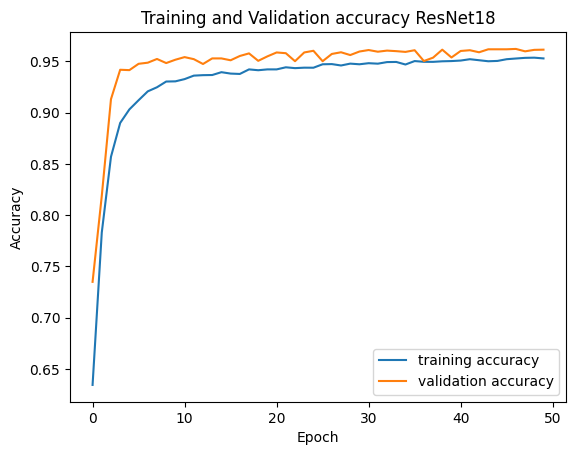

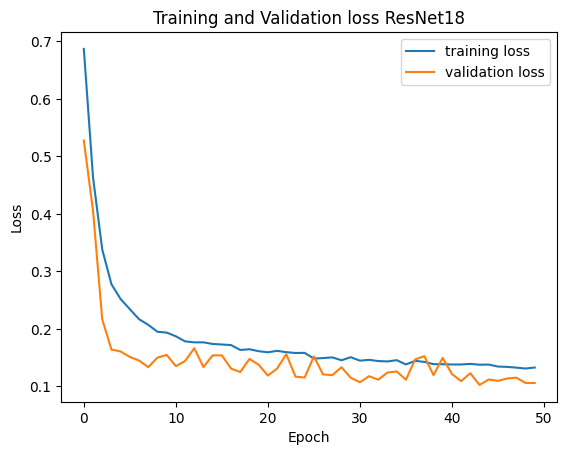

In [17]:
plt.plot(history_resnet18_50.history['accuracy'], label='training accuracy')
plt.plot(history_resnet18_50.history['val_accuracy'], label='validation accuracy')
plt.title('Training and Validation accuracy ResNet18')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history_resnet18_50.history['loss'], label='training loss')
plt.plot(history_resnet18_50.history['val_loss'], label='validation loss')
plt.title('Training and Validation loss ResNet18')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
ResNet18_50_train_loss = history_resnet18_50.history['loss']
ResNet18_50_val_loss = history_resnet18_50.history['val_loss']
ResNet18_50_train_acc = history_resnet18_50.history['accuracy']
ResNet18_50_val_acc = history_resnet18_50.history['val_accuracy']
print(ResNet18_50_train_loss)
print(ResNet18_50_val_loss)
print(ResNet18_50_train_acc)
print(ResNet18_50_val_acc)

[0.6870126724243164, 0.4636572301387787, 0.3381357789039612, 0.2775823175907135, 0.2517092823982239, 0.23417317867279053, 0.21664971113204956, 0.20692679286003113, 0.19484931230545044, 0.19341973960399628, 0.18692509829998016, 0.17817604541778564, 0.17639361321926117, 0.176405131816864, 0.17361077666282654, 0.17268158495426178, 0.17166900634765625, 0.16316084563732147, 0.16441528499126434, 0.1609969586133957, 0.15914270281791687, 0.1616186499595642, 0.15934009850025177, 0.15789999067783356, 0.15810048580169678, 0.14816147089004517, 0.14904505014419556, 0.15024374425411224, 0.14524729549884796, 0.15055511891841888, 0.14456196129322052, 0.14598898589611053, 0.14384768903255463, 0.14318345487117767, 0.14539308845996857, 0.13797800242900848, 0.14420963823795319, 0.1423998326063156, 0.1384529322385788, 0.13839547336101532, 0.13784705102443695, 0.13792024552822113, 0.1389348953962326, 0.13749994337558746, 0.137783482670784, 0.13430288434028625, 0.1336924433708191, 0.1324356645345688, 0.13086